## <font color=red>$$ #Deep Learning Course Project - Gesture Recognition$$</font>


In [1]:
# If this script is running on colab then below code is necessary or else no need to uncomment if its running on JARVIS Lab.
# If its running on Jarvis LAbs then it require some code changes,as this script is build and running on Jarvis so no need to change anything.

#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
#!unzip "/content/gdrive/MyDrive/Colab Notebooks/NN_Gesture_recognition/Project_data.zip"

In [38]:
## Checking the GPU configuration

!nvidia-smi

Wed Feb 15 09:45:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:1C:00.0 Off |                  Off |
| 33%   38C    P8    13W / 260W |   4957MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### <font color=red>Importing the necessary libraries</font>

In [19]:
# Importing the necessary libraries

!pip install scipy==1.1.0
from scipy import misc
import numpy as np
import os
#from scipy.ndimage import imread, imresize
#from scipy.misc import imread, imresize
from scipy.misc.pilutil import imread, imresize
#from skimage.transform import resize
#from imageio import imread
import datetime
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
#tf.set_random_seed(30)
tf.random.set_seed(30)
from tensorflow.keras.optimizers import Adam

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

>In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [7]:
project_folder='datasets/Project_data'

In [8]:
project_folder

'datasets/Project_data'

### <font color=red>Plotting</font>

In [9]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### <font color=red>Generator</font>

>This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [10]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### <font color=red>Model</font>

>Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.


#### **Sample Model**

In [37]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_21 (Activation)  (None, 15, 80, 80, 32)   

#### Sample Cropping

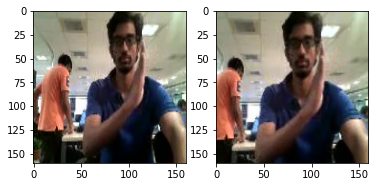

In [39]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])  

### Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
conv_3d1.train_model(conv_3d1_model)

>**We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error**

>ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [41]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


>So lets trade-off between these parameters


>Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [47]:
#conv_3d1=ModelConv3D1()
#conv_3d1.initialize_path(project_folder)
#conv_3d1.initialize_image_properties(image_height=100,image_width=100)
#conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
#conv_3d1_model=conv_3d1.define_model()
#print("Total Params:", conv_3d1_model.count_params())
#conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

>1. As we see from the above experiments "image resolution" and number of frames in sequence have more impact on training time than batch_size
2. We can consider the Batch Size around 15-40
3. We will change the resoulution 160X160, 120X120 according the model performance


### <font color=red>Model 1</font>

### Base Model - Batch Size = 40 and No. of Epochs = 15

In [48]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [49]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_58 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_41 (Activation)  (None, 10, 80, 80, 32)  

In [50]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5665 - categorical_accuracy: 0.4253
Epoch 00001: val_loss improved from inf to 1.43832, saving model to model_init_2023-02-1314_39_01.081305/model-00001-1.56650-0.42534-1.43832-0.37000.h5
17/17 [==============================] - 65s 4s/step - loss: 1.5665 - categorical_accuracy: 0.4253 - val_loss: 1.4383 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0527 - categorical_accuracy: 0.5988
Epoch 00002: val_loss did not improve from 1.43832
17/17 [==============================] - 61s 4s/step - loss: 1.0527 - categorical_accuracy: 0.5988 - val_loss: 3.7745 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7271 - categorical_accuracy: 0.7345
Epoch 00003: val_loss did not improve from 1.43832
17/17 [==============================] - 61s 4s/step - loss: 0.7271 - cate

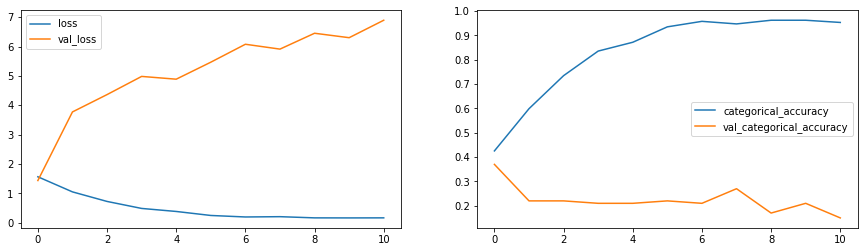

In [51]:
plot(history_model1)

>Model is clearly overfitting. :(

### <font color=red>Model 2</font>

### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [52]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_64 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_45 (Activation)  (None, 10, 80, 80, 32)  

In [53]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9284 - categorical_accuracy: 0.3891
Epoch 00001: val_loss improved from inf to 1.58946, saving model to model_init_2023-02-1314_50_20.193150/model-00001-1.92837-0.38914-1.58946-0.35000.h5
34/34 [==============================] - 120s 4s/step - loss: 1.9284 - categorical_accuracy: 0.3891 - val_loss: 1.5895 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4422 - categorical_accuracy: 0.5075
Epoch 00002: val_loss did not improve from 1.58946
34/34 [==============================] - 119s 4s/step - loss: 1.4422 - categorical_accuracy: 0.5075 - val_loss: 4.2298 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2959 - categorical_accuracy: 0.5475
Epoch 00003: val_loss did not improve from 1.58946
34/34 [==============================] - 122s 4s/step - loss: 1.2959 - c

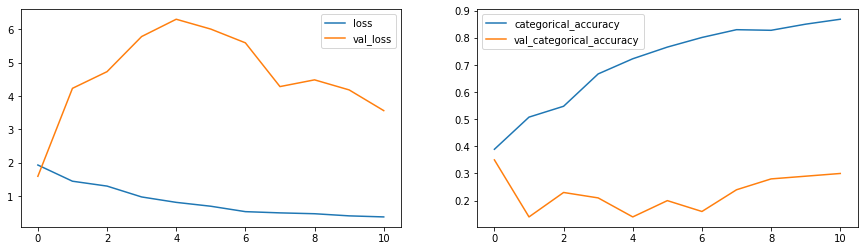

In [54]:
plot(history_model2)

>We can see val_loss did not improve from 1.58946 so earlystopping stops the epoch automatically!!
>1. Last Epoch stop on 11/25!! good job earlystopping ;)
2. Best weights save automatically. The validation accuracy of 30% and training accuracy of 86%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

### <font color=red>Model 3</font>


### Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 25

In [55]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [56]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_70 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_49 (Activation)  (None, 8, 60, 60, 32)   

In [57]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.2396 - categorical_accuracy: 0.2858
Epoch 00001: val_loss improved from inf to 1.75688, saving model to model_init_2023-02-1315_12_32.704206/model-00001-2.23959-0.28582-1.75688-0.21000.h5
23/23 [==============================] - 85s 4s/step - loss: 2.2396 - categorical_accuracy: 0.2858 - val_loss: 1.7569 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 3s - loss: 1.6029 - categorical_accuracy: 0.4712
Epoch 00002: val_loss did not improve from 1.75688
23/23 [==============================] - 82s 4s/step - loss: 1.6010 - categorical_accuracy: 0.4721 - val_loss: 2.3605 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 3s - loss: 1.3198 - categorical_accuracy: 0.5402
Epoch 00003: val_loss did not improve from 1.75688
23/23 [==============================] - 82s 4s/step - loss: 1.327

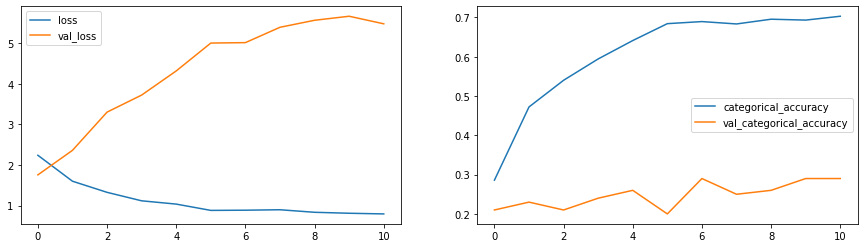

In [58]:
plot(history_model3)

>Model has a best validation accuracy of 30% and training accuracy of 71% .Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

### <font color=red>Model 4</font>

### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [59]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [60]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_76 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_53 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_53 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_77 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [61]:

print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0081 - categorical_accuracy: 0.3673
Epoch 00001: val_loss improved from inf to 2.44641, saving model to model_init_2023-02-1315_27_44.267259/model-00001-2.00805-0.36727-2.44641-0.25000.h5
34/34 [==============================] - 90s 3s/step - loss: 2.0081 - categorical_accuracy: 0.3673 - val_loss: 2.4464 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5173 - categorical_accuracy: 0.4744
Epoch 00002: val_loss did not improve from 2.44641
34/34 [==============================] - 84s 3s/step - loss: 1.5173 - categorical_accuracy: 0.4744 - val_loss: 2.5173 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4438 - categorical_accuracy: 0.4879
Epoch 00003: val_loss improved from 2.44641 to 2.39251, saving model to model_init_2023-02-1315_27_44.267259/model-00003-1.44

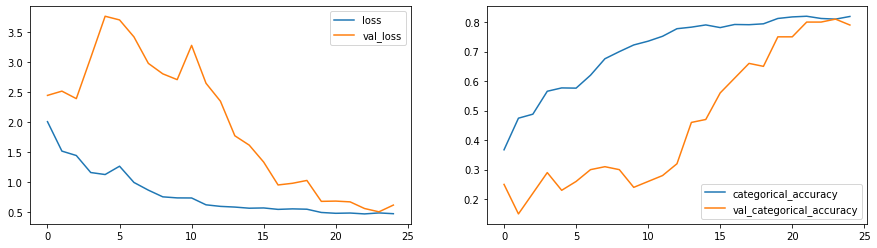

In [62]:
plot(history_model4)

>With more layers we dont see much performance improvement. We get a best validation accuracy of 79% . Let's try adding dropouts at the convolution layers

### <font color=red>Model 5</font>

### Adding dropout at convolution layers

In [63]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [64]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_86 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_61 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_61 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_87 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [65]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7799 - categorical_accuracy: 0.3786
Epoch 00001: val_loss improved from inf to 2.95859, saving model to model_init_2023-02-1316_03_20.888528/model-00001-1.77988-0.37858-2.95859-0.21000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.7799 - categorical_accuracy: 0.3786 - val_loss: 2.9586 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3138 - categorical_accuracy: 0.5053
Epoch 00002: val_loss did not improve from 2.95859
34/34 [==============================] - 85s 3s/step - loss: 1.3138 - categorical_accuracy: 0.5053 - val_loss: 6.1402 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1637 - categorical_accuracy: 0.5694
Epoch 00003: val_loss did not improve from 2.95859
34/34 [==============================] - 85s 3s/step - loss: 1.1637 - cate

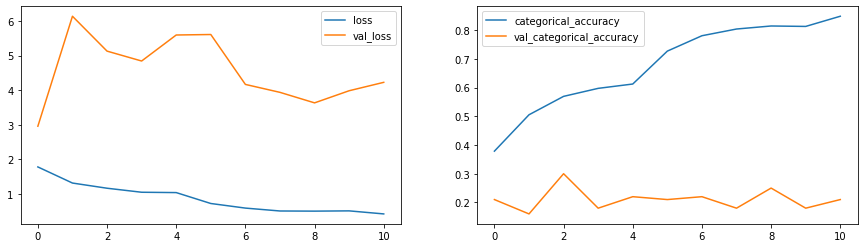

In [66]:
plot(history_model5)

>Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

>All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

### <font color=red>Model 6</font>


### Reducing the number of parameters

In [67]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [68]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_96 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 50, 50, 32)   

In [69]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8508 - categorical_accuracy: 0.3258
Epoch 00001: val_loss improved from inf to 1.76258, saving model to model_init_2023-02-1316_18_55.354920/model-00001-1.85076-0.32579-1.76258-0.23000.h5
34/34 [==============================] - 80s 2s/step - loss: 1.8508 - categorical_accuracy: 0.3258 - val_loss: 1.7626 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2353 - categorical_accuracy: 0.5226
Epoch 00002: val_loss did not improve from 1.76258
34/34 [==============================] - 79s 2s/step - loss: 1.2353 - categorical_accuracy: 0.5226 - val_loss: 2.3118 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9490 - categorical_accuracy: 0.6395
Epoch 00003: val_loss did not improve from 1.76258
34/34 [==============================] - 79s 2s/step - loss: 0.9490

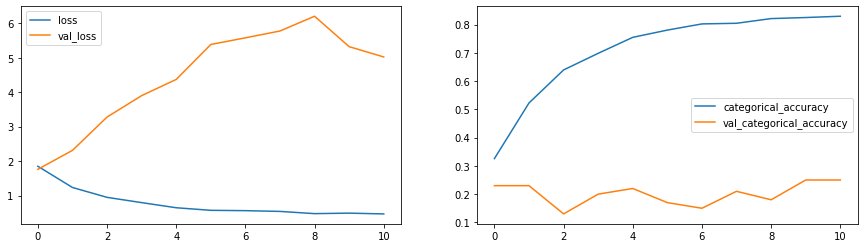

In [70]:
plot(history_model6)

> For the above low memory foot print model, we get the validation accuracy of 25%

### <font color=red>Model 7</font>

### Reducing the number of parameters again

In [71]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [72]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_72 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_102 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_73 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_73 (Activation)  (None, 8, 60, 60, 32)   

In [73]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9613 - categorical_accuracy: 0.2919
Epoch 00001: val_loss improved from inf to 1.67341, saving model to model_init_2023-02-1316_35_49.524179/model-00001-1.96128-0.29186-1.67341-0.13000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.9613 - categorical_accuracy: 0.2919 - val_loss: 1.6734 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1904 - categorical_accuracy: 0.5490
Epoch 00002: val_loss did not improve from 1.67341
34/34 [==============================] - 82s 2s/step - loss: 1.1904 - categorical_accuracy: 0.5490 - val_loss: 2.1200 - val_categorical_accuracy: 0.1200 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0255 - categorical_accuracy: 0.6033
Epoch 00003: val_loss did not improve from 1.67341
34/34 [==============================] - 83s 3s/step - loss: 1.0255

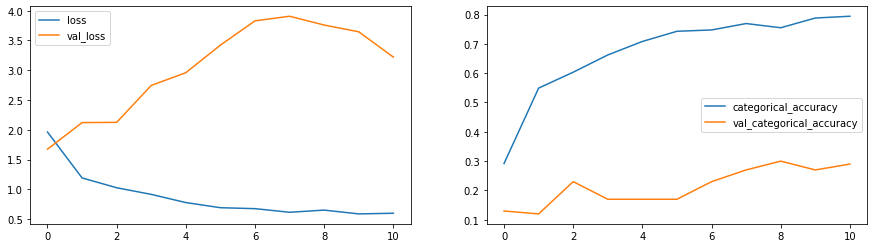

In [74]:
plot(history_model7)

> For the above low memory foot print model the validation accuracy of 29%

### <font color=red>Model 8 - CNN- LSTM Model</font>

In [28]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   1

In [77]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3655 - categorical_accuracy: 0.4155
Epoch 00001: val_loss improved from inf to 1.83219, saving model to model_init_2023-02-1316_51_12.168192/model-00001-1.36552-0.41554-1.83219-0.17000.h5
34/34 [==============================] - 94s 3s/step - loss: 1.3655 - categorical_accuracy: 0.4155 - val_loss: 1.8322 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0311 - categorical_accuracy: 0.6033
Epoch 00002: val_loss improved from 1.83219 to 1.82770, saving model to model_init_2023-02-1316_51_12.168192/model-00002-1.03114-0.60332-1.82770-0.20000.h5
34/34 [==============================] - 92s 3s/step - loss: 1.0311 - categorical_accuracy: 0.6033 - val_loss: 1.8277 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8222 - categorical_accuracy: 0.6878
Epoch 00003: val_los

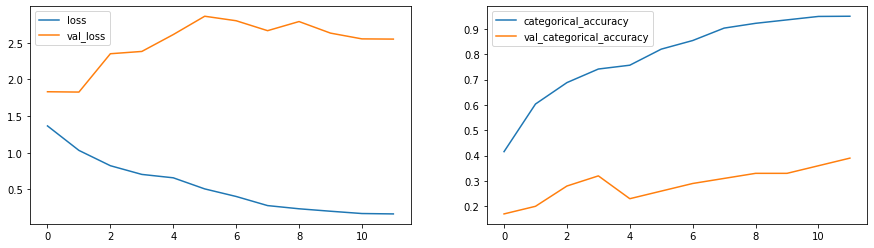

In [78]:
plot(history_model8)

>For CNN - LSTM model we get a validation accuracy of 40%

>As we see more cases of overfitting, lets augment the data with *slight rotation* as well and run the same set of models again. 

### Let's apply some data augmentation & check the model performance.

In [11]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

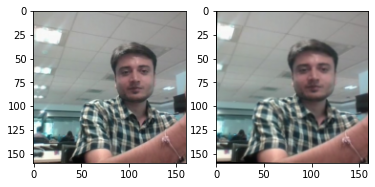

In [12]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

### <font color=red>Model 9 with Augmentation</font>

### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [81]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [82]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_76 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_113 (Ba  (None, 20, 160, 160, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_77 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_77 (Activation)  (None, 10, 80, 80, 32)  

In [83]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.0239 - categorical_accuracy: 0.3748
Epoch 00001: saving model to model_init_2023-02-1317_09_45.773801/model-00001-2.02394-0.37481-1.97628-0.18000.h5
34/34 [==============================] - 126s 4s/step - loss: 2.0239 - categorical_accuracy: 0.3748 - val_loss: 1.9763 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4376 - categorical_accuracy: 0.5196
Epoch 00002: saving model to model_init_2023-02-1317_09_45.773801/model-00002-1.43764-0.51961-2.75688-0.25000.h5
34/34 [==============================] - 123s 4s/step - loss: 1.4376 - categorical_accuracy: 0.5196 - val_loss: 2.7569 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1951 - categorical_accuracy: 0.5769
Epoch 00003: saving model to model_init_2023-02-1317_09_45.773801/model-00003-1.19507-0.5769

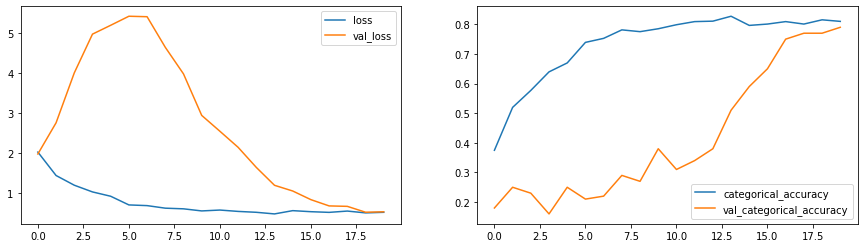

In [84]:
plot(history_model9)

>Hurray!! Validation Accuracy is 79%

### <font color=red>Model 10 with Augmentation</font>

### (2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [13]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2023-02-14 14:01:09.138839: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-14 14:01:09.138896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [15]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25


2023-02-14 14:01:16.236097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.2389 - categorical_accuracy: 0.3250
Epoch 00001: saving model to model_init_2023-02-1414_01_09.352007/model-00001-2.23893-0.32504-1.77647-0.16000.h5
23/23 [==============================] - 92s 4s/step - loss: 2.2389 - categorical_accuracy: 0.3250 - val_loss: 1.7765 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5322 - categorical_accuracy: 0.4729
Epoch 00002: saving model to model_init_2023-02-1414_01_09.352007/model-00002-1.53221-0.47285-2.37756-0.19000.h5
23/23 [==============================] - 88s 4s/step - loss: 1.5322 - categorical_accuracy: 0.4729 - val_loss: 2.3776 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.3046 - categorical_accuracy: 0.5520
Epoch 00003: saving model to model_init_2023-02-1414_01_09.352007/model-00003-1.30460-0.55204-3.56388-0.15000.h5
23/23 [=======

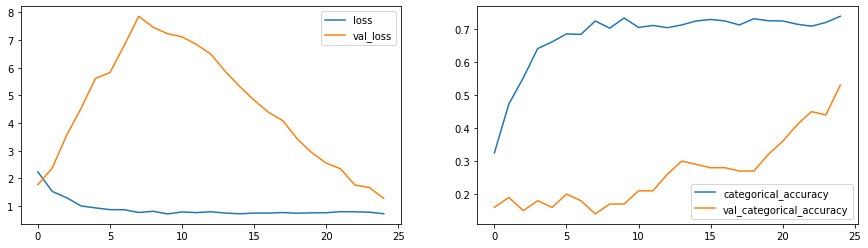

In [16]:
plot(history_model10)

>Validation Accuracy = 53% and Training Accuracy = 73%

### <font color=red>Model 11 with Augmentation</font>

### Adding more layers - Similar to model 4

In [17]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                      

In [19]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1823 - categorical_accuracy: 0.3047
Epoch 00001: saving model to model_init_2023-02-1414_36_23.655037/model-00001-2.18229-0.30468-1.88327-0.21000.h5
34/34 [==============================] - 91s 3s/step - loss: 2.1823 - categorical_accuracy: 0.3047 - val_loss: 1.8833 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.7253 - categorical_accuracy: 0.4193
Epoch 00002: saving model to model_init_2023-02-1414_36_23.655037/model-00002-1.72532-0.41931-2.59339-0.19000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.7253 - categorical_accuracy: 0.4193 - val_loss: 2.5934 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3721 - categorical_accuracy: 0.5241
Epoch 00003: saving model to model_init_2023-02-1414_36_23.655037/model-00003-1.37213-0.52413-

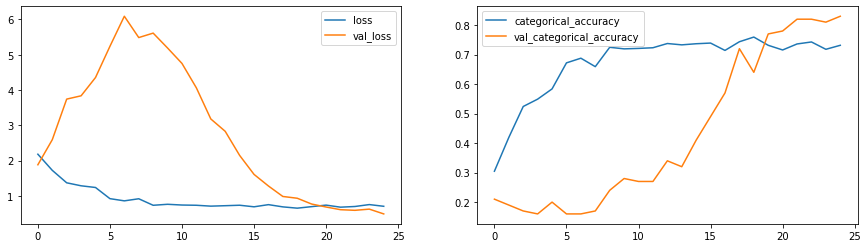

In [20]:
plot(history_model11)

>Validation Accuracy - 83% and Training Accuracy - 74%

### <font color=red>Model 12 with Augmentation</font>

### Adding dropouts - Similar to Model 5

In [21]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_13 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_17 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [23]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0242 - categorical_accuracy: 0.3160
Epoch 00001: saving model to model_init_2023-02-1415_12_39.359994/model-00001-2.02419-0.31599-2.30698-0.21000.h5
34/34 [==============================] - 85s 3s/step - loss: 2.0242 - categorical_accuracy: 0.3160 - val_loss: 2.3070 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5055 - categorical_accuracy: 0.4374
Epoch 00002: saving model to model_init_2023-02-1415_12_39.359994/model-00002-1.50550-0.43741-3.19311-0.23000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.5055 - categorical_accuracy: 0.4374 - val_loss: 3.1931 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3562 - categorical_accuracy: 0.5075
Epoch 00003: saving model to model_init_2023-02-1415_12_39.359994/model-00003-1.35615-0.50754-

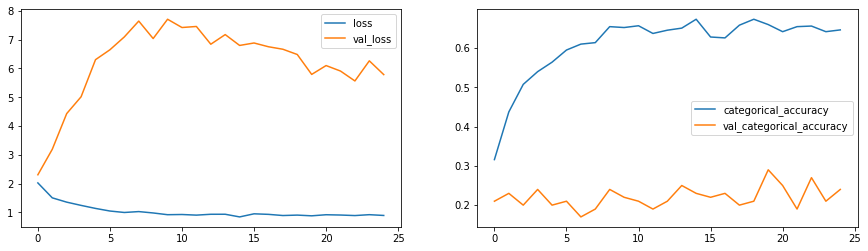

In [24]:
plot(history_model12)

>Model is overfitting badly !!

### <font color=red>Model 13 with Augmentation</font>

### Reducing network parameters - Similar to Model 6

In [13]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [26]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_26 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_21 (Activation)  (None, 8, 50, 50, 32)    

In [27]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7968 - categorical_accuracy: 0.3544
Epoch 00001: saving model to model_init_2023-02-1415_48_19.053181/model-00001-1.79683-0.35445-1.73580-0.17000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.7968 - categorical_accuracy: 0.3544 - val_loss: 1.7358 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1948 - categorical_accuracy: 0.5520
Epoch 00002: saving model to model_init_2023-02-1415_48_19.053181/model-00002-1.19482-0.55204-1.99624-0.19000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.1948 - categorical_accuracy: 0.5520 - val_loss: 1.9962 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9734 - categorical_accuracy: 0.6312
Epoch 00003: saving model to model_init_2023-02-1415_48_19.053181/model-00003-0.97336-0.63122-2

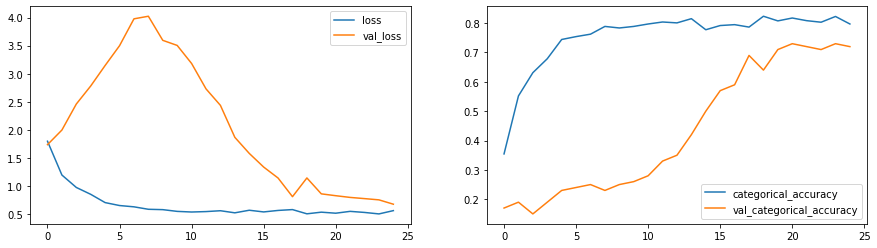

In [28]:
plot(history_model13)

>Validation Accuracy is around 72% and training accuracy si 79%

### <font color=red>Model 14 with Augmentation</font>

### Reducing network parameters again - Similar to model 7

In [29]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_32 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_25 (Activation)  (None, 8, 60, 60, 32)    

In [31]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9633 - categorical_accuracy: 0.3077
Epoch 00001: saving model to model_init_2023-02-1416_22_52.807734/model-00001-1.96332-0.30769-1.82064-0.16000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.9633 - categorical_accuracy: 0.3077 - val_loss: 1.8206 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3001 - categorical_accuracy: 0.4970
Epoch 00002: saving model to model_init_2023-02-1416_22_52.807734/model-00002-1.30009-0.49698-2.38785-0.17000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.3001 - categorical_accuracy: 0.4970 - val_loss: 2.3878 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0603 - categorical_accuracy: 0.5943
Epoch 00003: saving model to model_init_2023-02-1416_22_52.807734/model-00003-1.06031-0.59427-3

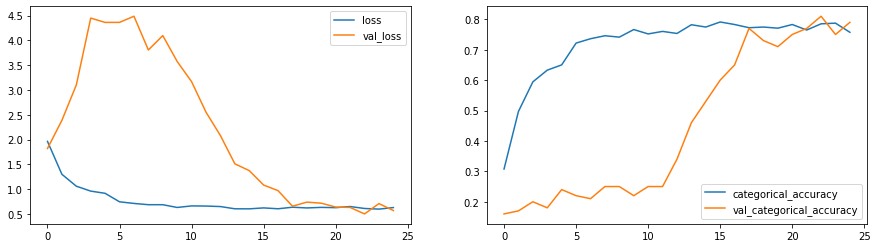

In [32]:
plot(history_model14)

>Validation Accuracy is around 79% and training accuracy si 75%

### <font color=red>Model 15 with Augmentation</font>

### CNN LSTM with GRU - Similar to Model 8

In [33]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [35]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4602 - categorical_accuracy: 0.3861
Epoch 00001: saving model to model_init_2023-02-1416_58_11.831877/model-00001-1.46022-0.38612-1.62775-0.21000.h5
34/34 [==============================] - 97s 3s/step - loss: 1.4602 - categorical_accuracy: 0.3861 - val_loss: 1.6277 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9455 - categorical_accuracy: 0.6493
Epoch 00002: saving model to model_init_2023-02-1416_58_11.831877/model-00002-0.94548-0.64932-1.77471-0.22000.h5
34/34 [==============================] - 94s 3s/step - loss: 0.9455 - categorical_accuracy: 0.6493 - val_loss: 1.7747 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7612 - categorical_accuracy: 0.7225
Epoch 00003: saving model to model_init_2023-02-1416_58_11.831877/model-00003-0.76122-0.72247-

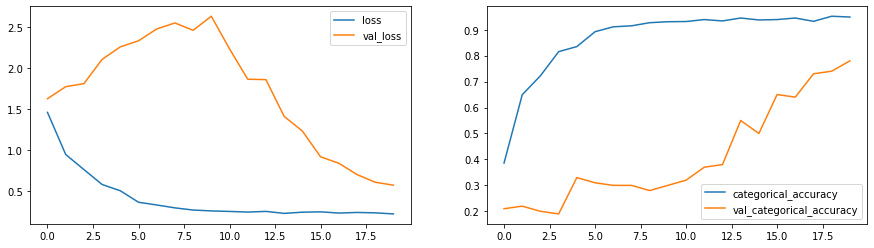

In [36]:
plot(history_model15)

>Validation Accuracy is around 78% and training accuracy si 94%, We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy.

### <font color=red>Model 16 - Let us bring in Transfer Learning !! :)</font>

In [14]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [15]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               5

In [17]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20


2023-02-14 18:04:53.291208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


133/133 [==============================] - ETA: 0s - loss: 1.2557 - categorical_accuracy: 0.4902
Epoch 00001: saving model to model_init_2023-02-1418_04_48.428505/model-00001-1.25567-0.49020-0.83838-0.74000.h5
133/133 [==============================] - 96s 687ms/step - loss: 1.2557 - categorical_accuracy: 0.4902 - val_loss: 0.8384 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7295 - categorical_accuracy: 0.7308
Epoch 00002: saving model to model_init_2023-02-1418_04_48.428505/model-00002-0.72951-0.73077-0.70819-0.75000.h5
133/133 [==============================] - 91s 686ms/step - loss: 0.7295 - categorical_accuracy: 0.7308 - val_loss: 0.7082 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5223 - categorical_accuracy: 0.8228
Epoch 00003: saving model to model_init_2023-02-1418_04_48.428505/model-00003-0.52226-0.82278-0.56731-0.79000.h5
133/13

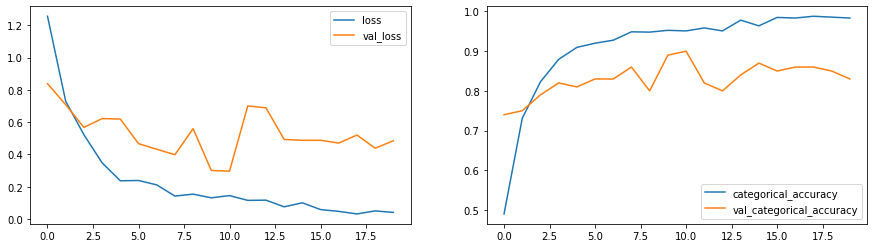

In [18]:
plot(history_model16)

>Validation Accuracy is around 83% and training accuracy si 98%, We are not training the mobilenet weights and we see validation accuracy is poor. Let's train them as well and observe if there is performance improvement

### <font color=red>Model 17 - Transfer Learning with GRU and training all weights</font>

In [26]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        #If adam_v2 doesn't support, please remove and let Adam() be the optimiser.
        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

In [21]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.9110 - categorical_accuracy: 0.6621
Epoch 00001: saving model to model_init_2023-02-1418_34_21.640184/model-00001-0.91102-0.66214-0.45003-0.87000.h5
133/133 [==============================] - 92s 666ms/step - loss: 0.9110 - categorical_accuracy: 0.6621 - val_loss: 0.4500 - val_categorical_accuracy: 0.8700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.3649 - categorical_accuracy: 0.8854
Epoch 00002: saving model to model_init_2023-02-1418_34_21.640184/model-00002-0.36492-0.88537-0.30467-0.86000.h5
133/133 [==============================] - 85s 644ms/step - loss: 0.3649 - categorical_accuracy: 0.8854 - val_loss: 0.3047 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2600 - categorical_accuracy: 0.9216
Epoch 00003: saving model to model_init_2023-02-1418_34_21.640184/model-00003-0.25995-

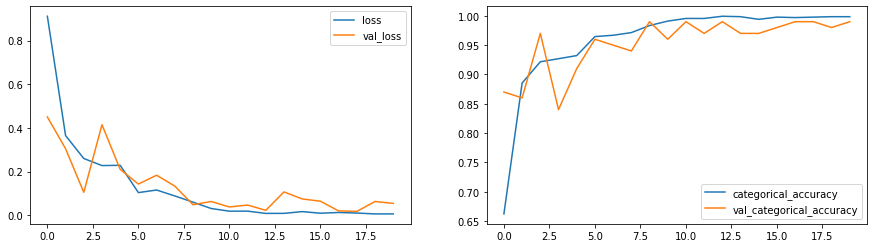

In [22]:
plot(history_model17)

>Awesome results! 99.8% Training accuracy and 99% validation accuracy :)

### <font color=red>Consolidated Final Models</font>

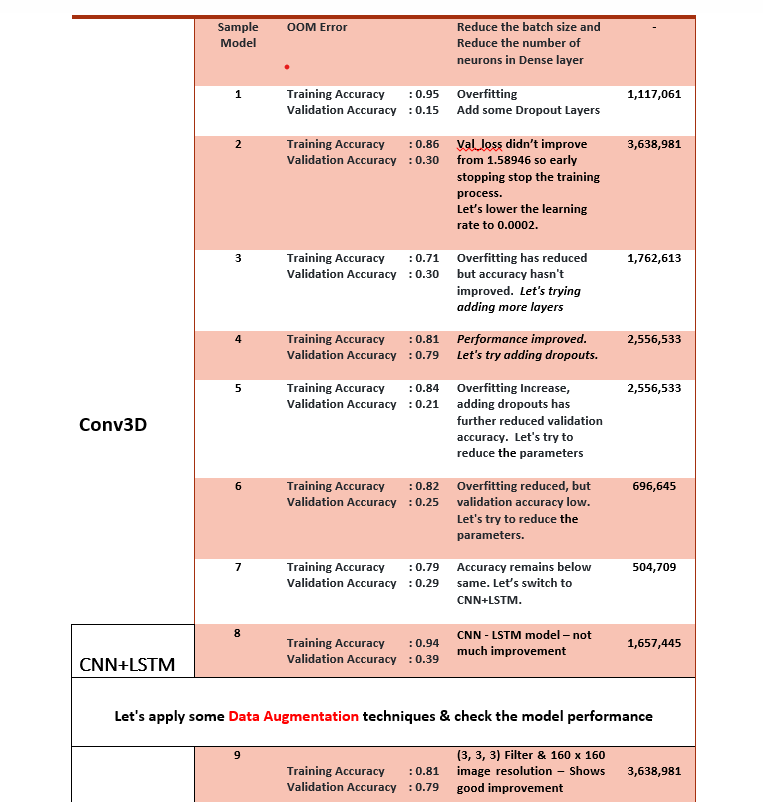

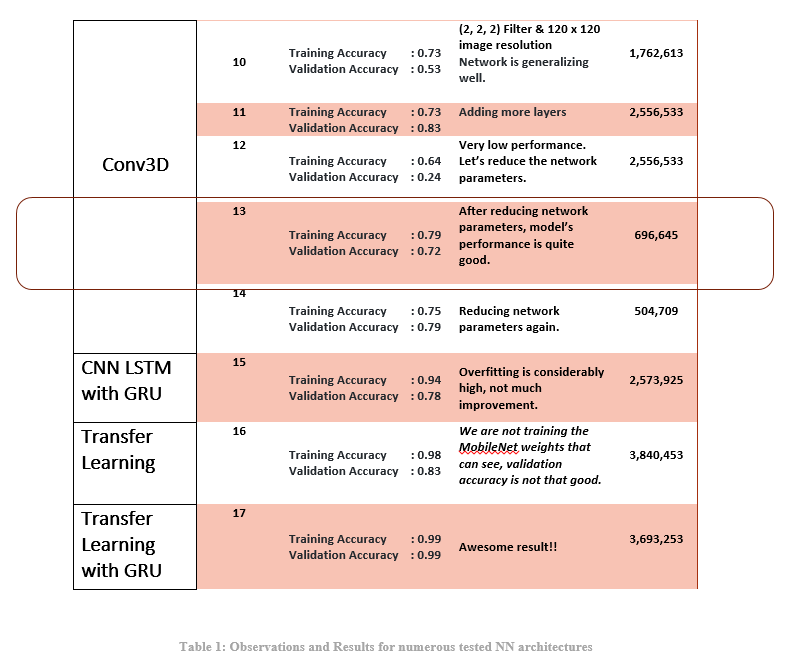

After doing all the experiments, we finalized Model 13 – Conv3D with Augmentation, which performed well.
Reason:
1. (Training Accuracy: 79%, Validation Accuracy: 72%)

2. Number of Parameters (696,645) less according to other models’ performance
3. Learning rate gradually decreasing after some Epochs


The best weights of Conv3D model-00025-0.56065-0.79713-0.67504-0.72000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below

### <font color=red>Loading model and Testing</font>

In [17]:
import time
from keras.models import load_model
model = load_model('model_init_2023-02-1415_48_19.053181/model-00025-0.56065-0.79713-0.67504-0.72000.h5')

2023-02-15 13:17:30.277424: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-15 13:17:30.277489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [14]:
test_generator=ModelConv3D13()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=100,image_width=100)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [15]:
batch_labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [18]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

2023-02-15 13:17:35.639589: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


[3 0 3 3 2 1 1 4 0 0 3 1 1 1 3 0 0 1 4 3]


## <font color=red>$$ # END $$</font>